In [13]:
!pip install category_encoders
!pip install texthero

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 238 kB 9.9 MB/s 
     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 10.4 MB 5.8 MB/s 
     |████████████████████████████████| 366 kB 3.4 MB/s 
     |████████████████████████████████| 24.2 MB 5.4 MB/s 
     |████████████████████████████████| 6.8 MB 11.1 MB/s 
     |████████████████████████████████| 82 kB 2.4 MB/s 
     |████████████████████████████████| 723 kB 15.3 MB/s 
     |████████████████████████████████| 293 kB 2.6 MB/s 
     |████████████████████████████████| 284 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 9.9 MB/s 
     |████████████████████████████████| 117 kB 17.9 MB/s 
  Cr

In [40]:
import pandas as pd
import pathlib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import texthero as hero
from texthero import preprocessing

from sklearn import metrics
from sklearn.model_selection import GroupKFold, KFold

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import model_selection

In [41]:
DATA_DIR = pathlib.Path('/home/knikaido/work/atma8/data/')
OUTPUT_DIR = './sub22/'
train_csv_path = DATA_DIR / 'train.csv'
test_csv_path = DATA_DIR / 'test.csv'

In [42]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [43]:
whole_df_nan = whole_df.isnull()

In [44]:
train_Year_df = whole_df[whole_df_nan['Year_of_Release'] == False]
test_Year_df = whole_df[whole_df_nan['Year_of_Release'] == True]

In [45]:
train_Year_df.reset_index(drop=True, inplace=True)
test_Year_df.reset_index(drop=True, inplace=True)

In [52]:
train_column = train_df.columns

In [53]:
X_column = []
for s in train_column:
    if not'Sales' in s:
        X_column.append(s)

In [54]:
train_df_drop = train_Year_df[X_column]
test_df = test_Year_df

In [55]:
# User_Scoreの変換
def make_user_score(df):
    d = df['User_Score'].copy()
    d[d == 'tbd'] = 'nan'
    df.loc[:,'User_Score'] = d
    
    return df

In [56]:
train_df_drop = make_user_score(train_df_drop)
test_df = make_user_score(test_df)

In [57]:
train_df_drop.drop(['Year_of_Release'], axis=1, inplace=True)
test_df.drop(['Year_of_Release'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4167: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [58]:
whole_df = pd.concat([train_df_drop, test_df], ignore_index=True)

In [59]:
# year_mean = whole_df.groupby('Platform').mean()['Year_of_Release'].astype('int')
# year_mean.name = 'Year_Mean'

In [60]:
# whole_df = pd.merge(whole_df, year_mean, on='Platform', how='left')
# whole_df['Year_of_Release'].fillna(whole_df['Year_Mean'], inplace=True)
# whole_df.drop('Year_Mean', axis=1, inplace=True)

# train_df_drop = whole_df.iloc[:len(train_df_drop), :]
# test_df = whole_df.iloc[len(train_df_drop):, :]


In [61]:
def add_pub_dev_info(df1, df2, tgt, col, val='Name', func='count'):
    whole_df = pd.concat([df1, df2], ignore_index=True)
    plat_pivot = whole_df.pivot_table(index=tgt, columns=col, values=val, aggfunc=func).reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = 5
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt[:3] +  '_' + col+ '_' + val + '_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    whole_df = pd.merge(whole_df, plat_pca_df, on=tgt, how='left')

    df1 = whole_df.iloc[:len(df1), :]
    df2 = whole_df.iloc[len(df1):, :]
    return df1, df2



In [62]:
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Platform')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Genre')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Rating')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Critic_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Critic_Count')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'User_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'User_Count')

train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Platform')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Genre')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Rating')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Critic_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Critic_Count')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'User_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'User_Count')

train_df_drop

,Name,Platform,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,...,Dev_Genre_Name_pca_0,Dev_Genre_Name_pca_1,Dev_Genre_Name_pca_2,Dev_Genre_Name_pca_3,Dev_Genre_Name_pca_4,Dev_Rating_Name_pca_0,Dev_Rating_Name_pca_1,Dev_Rating_Name_pca_2,Dev_Rating_Name_pca_3,Dev_Rating_Name_pca_4
0,Defender,2600,Misc,Atari,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Checkers,2600,Misc,Atari,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Asteroids,2600,Shooter,Atari,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Missile Command,2600,Shooter,Atari,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Frogger,2600,Action,Parker Bros.,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16445,SD Gundam G Generation Genesis,PSV,Strategy,Namco Bandai Games,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16446,SD Gundam G Generation Genesis,PS4,Strategy,Namco Bandai Games,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16447,Battle Worlds: Kronos,PC,Strategy,Nordic Games,71.0,15.0,7.1,71.0,KING Art,NaN,...,-1.214031,-1.128777,-0.195859,-0.396829,-0.310216,-2.460225,0.407896,-0.506558,-0.941300,-0.002172
16448,Codename: Panzers Complete Collection,PC,Strategy,Nordic Games,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# cols = 'Name_0'
# fig, ax = plt.subplots(figsize = (16, 6))

# sns.distplot(train_df_drop['Pu_Critic_Score_pca_0'].values, 
#              hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
# sns.distplot(test_df['Pu_Critic_Score_pca_0'].values, 
#              hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
# ax.set_title(f'Distribution for {cols}', fontsize=16)
# sns.despine(left=True, bottom=True)
# plt.legend()
# plt.show()

In [64]:
# train_df_drop

In [65]:
# plt.plot(train_df_drop['plat_pca_1'])
# plt.plot(train_df_drop['plat_pca_0'])
# plt.plot(train_df_drop['Publisher'])

In [66]:
# plt.plot(train_df_drop['Publisher'])

In [67]:
# train_df_drop

In [68]:
# Ratingの変換

In [69]:
def encode_label(train, test):
    cate_col = ['Rating', 'Platform', 'Genre']
    oe = ce.OrdinalEncoder(cols=cate_col, drop_invariant=True, handle_missing='return_nan')
    train.loc[:,cate_col] = oe.fit_transform(train[cate_col])
    test.loc[:,cate_col] = oe.transform(test[cate_col])
    return train, test

In [70]:
train_df_drop, test_df = encode_label(train_df_drop, test_df)

/home/user/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [71]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]

In [72]:
def translate_name(df1, df2):
    df = pd.concat([df1, df2])
    tif_vec = hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline))
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline)))
    tif_vec_l = []
    for i in range(len(tif_vec)):
        tif_vec_l.append(tif_vec.values[i])
    tif_vec_np = np.array(tif_vec_l)

#     km = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
#     y_km = km.fit_predict(tif_vec_np)
#     df['kmeans_name'] = y_km
    
    pca = PCA(n_components=30)
    tif_vec_pca = pca.fit_transform(tif_vec_np) 
#     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
#     tif_vec_pca = tsne.fit_transform(tif_vec_np)
    
    for i in range(tif_vec_pca.shape[1]):
        c_ = 'Name_' + str(i)
        df[c_] = tif_vec_pca[:, i]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [73]:
train_df_drop, test_df = translate_name(train_df_drop, test_df)


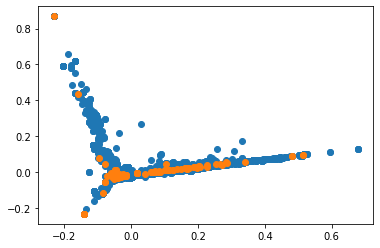

In [74]:
plt.scatter(train_df_drop['Name_0'].values, train_df_drop['Name_1'].values)
plt.scatter(test_df['Name_0'].values, test_df['Name_1'].values)

In [75]:
def translate_name_wav2vec(df1, df2):
    df = pd.concat([df1, df2])
    C_Name = hero.clean(df['Name'], pipeline=custom_pipeline)
    sentences = []
    for sentence in C_Name:
        data = sentence.split()
        sentences.append(data)
    model = word2vec.Word2Vec(sentences,
                              size=200,
                              min_count=1,
                              window=5,
                              iter=20,
                              sg = 0)
    w_vec = []
    for sentence in C_Name:
        data = sentence.split()
        tmp = np.zeros(200)
        for d in data:
            tmp += model[d]
        w_vec.append(tmp)
    w_vec = np.array(w_vec)
    
    pca = PCA(n_components=30)
    w_vec_pca = pca.fit_transform(w_vec) 
#     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
#     w_vec_pca = tsne.fit_transform(w_vec_pca)
    for i in range(w_vec_pca.shape[1]):
        c_ = 'W_Name_' + str(i)
        df[c_] = w_vec_pca[:, i]
        
        
        
#     pca = PCA(n_components=10)
#     w_vec_pca = pca.fit_transform(w_vec)
    
#     df['Name_0'] = w_vec_pca[:, 0]
#     df['Name_1'] = w_vec_pca[:, 1]
#     df['Name_2'] = w_vec_pca[:, 2]
#     df['Name_3'] = w_vec_pca[:, 3]
#     df['Name_4'] = w_vec_pca[:, 4]
#     df['Name_5'] = w_vec_pca[:, 5]
#     df['Name_6'] = w_vec_pca[:, 6]
#     df['Name_7'] = w_vec_pca[:, 7]
#     df['Name_8'] = w_vec_pca[:, 8]
#     df['Name_9'] = w_vec_pca[:, 9]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [76]:
train_df_drop, test_df = translate_name_wav2vec(train_df_drop, test_df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [77]:
def add_pub_dev_info_mean(df1, df2, tgt, col, val, func=np.mean):
    whole_df = pd.concat([df1, df2], ignore_index=True)
    plat_pivot = whole_df.pivot_table(index=tgt, columns=col, values=val, aggfunc=func).reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = 5
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt[:3] +  '_' + col+ '_' + val + '_pca_mean'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    whole_df = pd.merge(whole_df, plat_pca_df, on=tgt, how='left')

    df1 = whole_df.iloc[:len(df1), :]
    df2 = whole_df.iloc[len(df1):, :]
    return df1, df2

In [78]:
for i in range(30):
    train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Publisher', 'Genre', 'Name_'+str(i))
train_df_drop
for i in range(30):
    train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Publisher', 'Platform', 'Name_'+str(i))
train_df_drop
for i in range(30):
    train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Publisher', 'Rating', 'Name_'+str(i))
# train_df_drop

# for i in range(30):
#     train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Publisher', 'Genre', 'W_Name_'+str(i))
# train_df_drop
# for i in range(30):
#     train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Publisher', 'Platform', 'W_Name_'+str(i))
# train_df_drop
# for i in range(30):
#     train_df_drop, test_df = add_pub_dev_info_mean(train_df_drop, test_df, 'Publisher', 'Rating', 'W_Name_'+str(i))
# train_df_drop

In [79]:
drop_c = ['Name', 'Publisher', 'Developer']
train_df_drop.drop(drop_c, axis=1, inplace=True)
test_df.drop(drop_c, axis=1, inplace=True)
train_df_drop

,Platform,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating,NA_Sales,EU_Sales,JP_Sales,...,Pub_Rating_Name_28_pca_mean0,Pub_Rating_Name_28_pca_mean1,Pub_Rating_Name_28_pca_mean2,Pub_Rating_Name_28_pca_mean3,Pub_Rating_Name_28_pca_mean4,Pub_Rating_Name_29_pca_mean0,Pub_Rating_Name_29_pca_mean1,Pub_Rating_Name_29_pca_mean2,Pub_Rating_Name_29_pca_mean3,Pub_Rating_Name_29_pca_mean4
0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.003649,0.001543,0.009786,0.000363,-0.000637,0.004067,-0.005124,-0.003326,0.001148,0.000209
1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.003649,0.001543,0.009786,0.000363,-0.000637,0.004067,-0.005124,-0.003326,0.001148,0.000209
2,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.003649,0.001543,0.009786,0.000363,-0.000637,0.004067,-0.005124,-0.003326,0.001148,0.000209
3,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.003649,0.001543,0.009786,0.000363,-0.000637,0.004067,-0.005124,-0.003326,0.001148,0.000209
4,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16445,28.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.027126,0.014070,0.027931,0.011308,-0.000659,-0.000151,0.010922,-0.002540,0.004895,-0.000978
16446,30.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.027126,0.014070,0.027931,0.011308,-0.000659,-0.000151,0.010922,-0.002540,0.004895,-0.000978
16447,5.0,12.0,71.0,15.0,7.1,71.0,NaN,NaN,NaN,NaN,...,-0.011350,0.000920,-0.004490,-0.007534,-0.000392,0.014192,-0.021183,-0.008625,0.003874,0.001786
16448,5.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.011350,0.000920,-0.004490,-0.007534,-0.000392,0.014192,-0.021183,-0.008625,0.003874,0.001786


In [80]:
train_df_drop = train_df_drop.astype('float64')
test_df = test_df.astype('float64')

In [81]:
X = train_df_drop
y = train_Year_df['Year_of_Release'].astype('float64')
groups = train_df['Publisher']

In [33]:
def create_folds(data, target_col):
    num_bins = np.int(1 + np.log2(len(data)))
    bins = pd.cut(
        data[target_col],
        bins=num_bins,
        labels=False
    )
    kf = model_selection.StratifiedKFold(n_splits=10)
    fold_ids = list(kf.split(X=data, y=bins.values))
    return fold_ids

# fold_ids = create_folds(train_df, "Global_Sales")

/home/user/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



In [85]:
from sklearn.model_selection import StratifiedKFold

# kfoldの分割数
k = 10
# kf = KFold(n_splits=k, shuffle=True, random_state=0)
# kf = GroupKFold(n_splits=k)
skf = StratifiedKFold(n_splits=10)

lgbm_params = {'objective': 'regression',
              "metric":"rmse",
               'max_dapth': 8,
              "learning_rate": 0.01,
               'colsample_bytree': 0.8}

rmsle_train_list = []
rmsle_eval_list = []

pred_test_np = np.zeros([k, len(test_df)])
oof_pred = np.zeros_like(y, dtype=np.float)

# kfoldで分割
for i, (train_index, test_index) in enumerate(skf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
#     y_train = np.log1p(y_train)
#     y_test = np.log1p(y_test)

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    # 学習
    model = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets=[lgb_eval, lgb_train],
                        num_boost_round=10000,
                        early_stopping_rounds=1000,
                        verbose_eval=200)

    predict_train = model.predict(X_train, num_iteration=model.best_iteration)
    predict_eval = model.predict(X_test, num_iteration=model.best_iteration)
    oof_pred[test_index] = predict_eval
    
    rmsle_train = np.sqrt(mean_squared_error(y_train, predict_train))
    rmsle_eval = np.sqrt(mean_squared_error(y_test, predict_eval))
    print(f'epoch: {i} RMSLE_train: {rmsle_train}, RMSLE_eval: {rmsle_eval}')
    rmsle_train_list.append(rmsle_train)
    rmsle_eval_list.append(rmsle_eval)
    
    pred_test_np[i] = model.predict(test_df, num_iteration=model.best_iteration)
    
print(f'RMSLE_train_mean: {np.mean(rmsle_train_list)}, RMSLE_eval_mean: {np.mean(rmsle_eval_list)}')

    # predict_probaが0.5以上なら1とする
#     predict = [0 if i < 0.5 else 1 for i in predict_proba]

#     auc, precision, recall = get_evaluate(y_test, predict)

#     print('AUC:{}, precision:{}, recall:{}'.format(auc, precision, recall))

#     auc_list.append(auc)
#     precision_list.append(precision)
#     recall_list.append(recall)

# # kfoldの平均値を取得
# print('Kfold平均 AUC:{}, precision:{}, recall:{}'.format(np.mean(auc_list), 
#                                                          np.mean(precision_list), 
#                                                          np.mean(recall_list)))

/home/user/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 2.08312	valid_0's rmse: 2.10871
[400]	training's rmse: 1.71428	valid_0's rmse: 1.85856
[600]	training's rmse: 1.59657	valid_0's rmse: 1.86435
[800]	training's rmse: 1.52146	valid_0's rmse: 1.86477
[1000]	training's rmse: 1.46016	valid_0's rmse: 1.86091
[1200]	training's rmse: 1.40763	valid_0's rmse: 1.86437
[1400]	training's rmse: 1.35649	valid_0's rmse: 1.86774
Early stopping, best iteration is:
[445]	training's rmse: 1.68147	valid_0's rmse: 1.84933
epoch: 0 RMSLE_train: 1.6814671857437924, RMSLE_eval: 1.849327250709574
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 2.07394	valid_0's rmse: 2.20725
[400]	training's rmse: 1.70046	valid_0's rmse: 1.94824
[600]	training's rmse: 1.58656	valid_0's rmse: 1.92653
[800]	training's rmse: 1.51356	valid_0's rmse: 1.91665
[1000]	training's rmse: 1.45186	valid_0's rmse: 1.9101
[1200]	training's rmse: 1.39934	valid_0's rmse: 1

In [86]:
print(np.sqrt(mean_squared_error(y, oof_pred)))

1.903618622032295


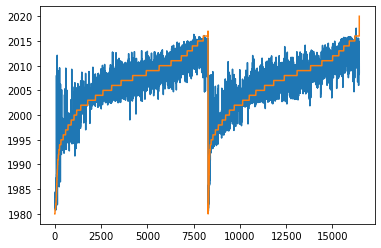

In [89]:
plt.plot(oof_pred)
plt.plot(y)


In [67]:
oof_df = pd.DataFrame(oof_pred, columns=['Global_Sales'])
oof_df.to_csv(OUTPUT_DIR + "oof20.csv", index = False)

In [68]:
pred_test_mean = np.mean(pred_test_np, axis=0)
pred_test_exp = np.expm1(pred_test_mean)

In [69]:
sub = pd.read_csv(DATA_DIR / 'atmaCup8_sample-submission.csv')
sub['Global_Sales'] = pred_test_exp
sub.to_csv(OUTPUT_DIR + "sub20.csv", index = False)

In [70]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    model = models
#     for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type='gain')
    _df['column'] = feat_train_df.columns
    _df['fold'] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

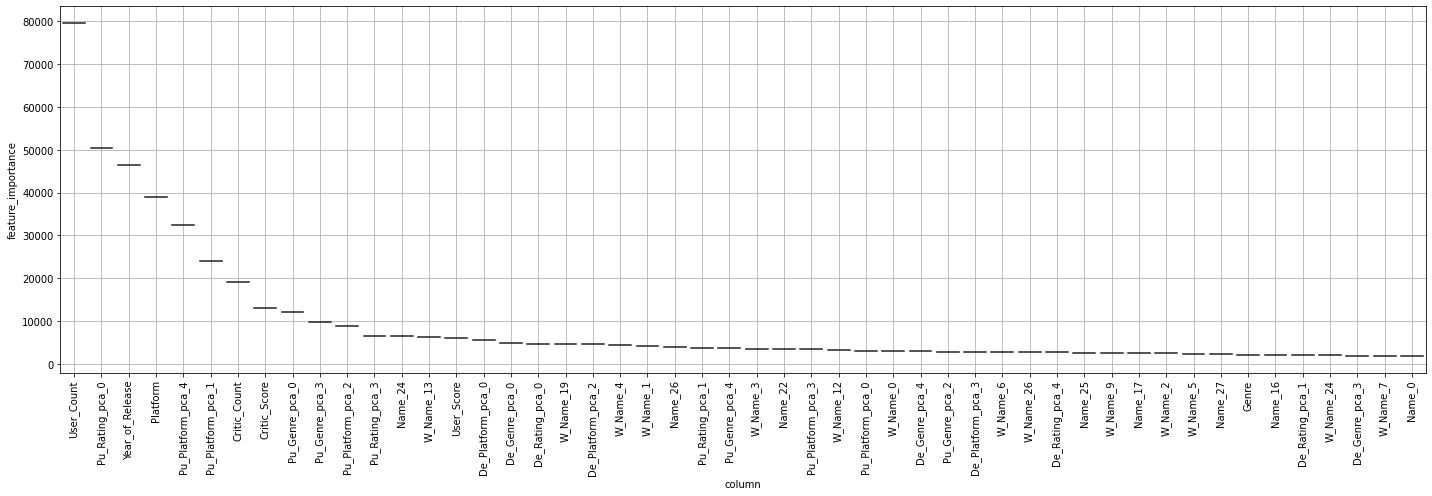

In [71]:
fig, ax = visualize_importance(model, X)


In [72]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train_df_drop.columns, columns=['importance'])
importance.sort_values(['importance'])

,importance
Name_2,323.877692
Pu_Genre_pca_1,496.322214
Name_7,515.143147
De_Rating_pca_3,518.100210
De_Genre_pca_1,616.086339
...,...
Pu_Platform_pca_4,32338.678168
Platform,38917.579210
Year_of_Release,46552.477817
Pu_Rating_pca_0,50343.438889


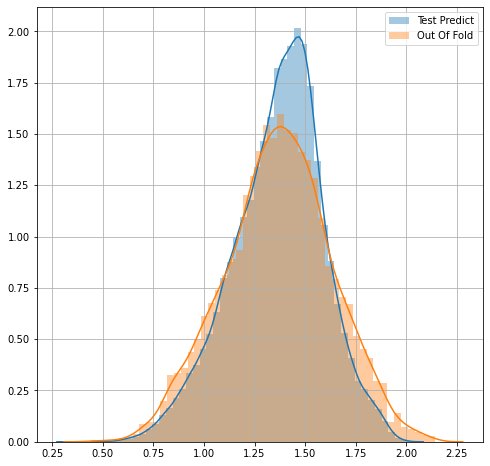

In [73]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred_test_np), label='Test Predict')
sns.distplot(np.log1p(oof_pred), label='Out Of Fold')
ax.legend()
ax.grid()

<AxesSubplot:>

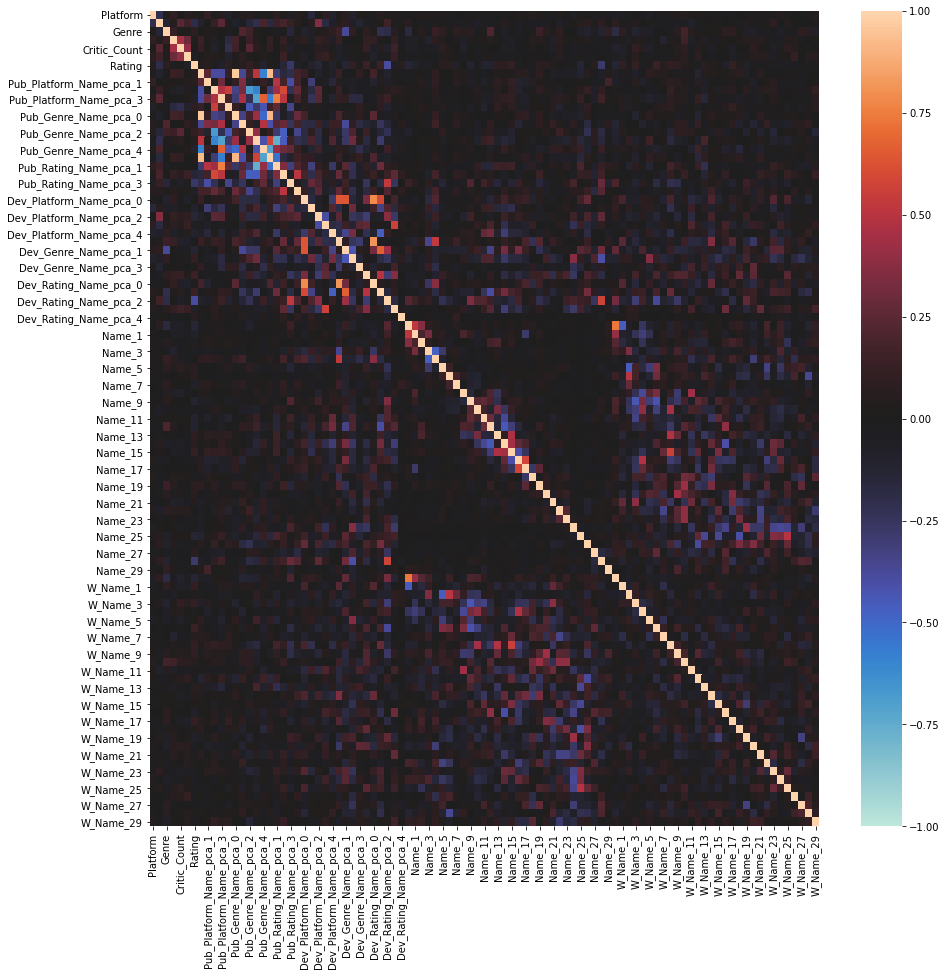

In [32]:
plt.figure(figsize=(15,15))
sns.heatmap(train_df_drop.corr(), vmax=1, vmin=-1, center=0)
# train_df_drop.corr().style.background_gradient(axis=None)